In [1]:
import numpy as np
from ExtendedTSSRP import ExtendedTSSRP
from MSSRP import MSSRP
from TSSRP import TSSRP
import time
nmodels = 3
model_all = [[] for i in range(nmodels)]
model_name = ['E_srp_T2','E_srp_T1_Max','srp_M']

# Tonnage

In [2]:
import scipy.io as io
import matplotlib.pyplot as plt
import numpy as np
data = io.loadmat('data/tonnage.mat')

In [3]:
X = data['X']
y = data['y'][:,0]
np.moveaxis(X,0,1).shape

(4, 1201, 582)

In [4]:
vx = np.moveaxis(X,0,1).reshape(-1,582).T # Reshape the data
y[y==5]=2 # Relabel the label '5' to '2' 

data_normal = vx[y==0] # Select label 0 as normal sample
nNormalSample = vx[y==0].shape[0]
p = vx.shape[1] # Dimensionality of the data
nFailureMode = np.max(y)-1 # Falure Mode Number
nAbnormalSample = vx[y==1].shape[0] # sample number
data_abnormal = np.zeros((nFailureMode,nAbnormalSample,p)) # 5 failure modes, 69 samples, with 4804 dimension
for i in range(1,nFailureMode+1):
    data_abnormal[i-1] = vx[y==i]

In [5]:
data_normal_diff = np.diff(data_normal,n=1,axis=0)
data_normal_diff_mean = np.mean(data_normal_diff,axis=0)
data_normal_diff = data_normal_diff - data_normal_diff_mean[np.newaxis,:]
data_normal_diff = data_normal_diff/np.std(data_normal_diff)

data_abnormal_diff = np.diff(data_abnormal,n=1,axis=1)
data_abnormal_diff = data_abnormal_diff - data_normal_diff_mean[np.newaxis,np.newaxis,:]
data_abnormal_diff = data_abnormal_diff/np.std(data_abnormal_diff)

In [6]:
data_abnormal_diff.shape

(3, 68, 4804)

In [7]:
from sklearn.decomposition import PCA
num_components = 15
M = np.zeros((4804, num_components*nFailureMode))
for i in range(nFailureMode):
    model_abnormal = PCA(svd_solver='auto', n_components=num_components)
    model_abnormal.fit(data_abnormal_diff[i])
    M[:,i*num_components:(i+1)*num_components] = model_abnormal.components_.T

In [8]:
normal_index = np.random.choice(nNormalSample-1, size=100, replace=True)
abormal_index = np.random.choice(nAbnormalSample-1, size=100, replace=True)

all_Simulated_data = [[] for i in range(nFailureMode)]
for i in range(nFailureMode):
    all_Simulated_data[i] = np.concatenate((data_normal_diff[normal_index,:],data_abnormal_diff[i][abormal_index,:]))

In [9]:
p = 4804 # Number of dimensions
c = 0.1 # Target meanshift is c * M
k = num_components*nFailureMode # Number of failuer Mode
Ks = 5   #Select Top Ks control chart
nsensors = 500 # Number of selected sensors
T0 = 100
model_all[0] = ExtendedTSSRP(p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T2')
model_all[1] = ExtendedTSSRP(p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T1_Max')
model_all[2] = MSSRP(p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T2')
failure_idx = 0
model_idx = 0

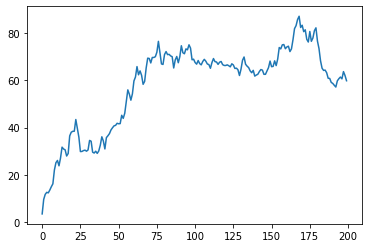

In [12]:
sequential_statistics_topRsum, sensor_selection_history, failure_mode_history, i,sequential_statistics= model_all[model_idx].compute_monitoring_statistics(all_Simulated_data[failure_idx],T0,-1)
plt.plot(sequential_statistics_topRsum)

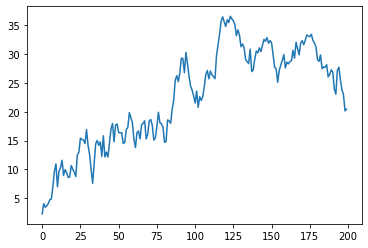

In [25]:
sequential_statistics_topRsum, sensor_selection_history, failure_mode_history, i,sequential_statistics= model_all[1].compute_monitoring_statistics(all_Simulated_data[failure_idx],T0,-1)
plt.plot(sequential_statistics_topRsum)

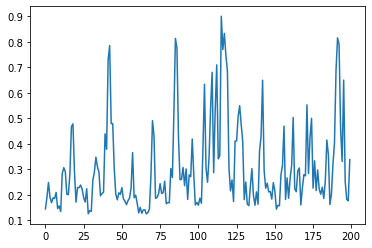

In [10]:
sequential_statistics_topRsum, sensor_selection_history, failure_mode_history, i,sequential_statistics= model_all[2].compute_monitoring_statistics(all_Simulated_data[failure_idx],T0,-1)
plt.plot(sequential_statistics_topRsum)